In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
sc.settings.verbosity = 0
#from anndata import AnnData
import scipy
#from numpy.linalg import svd


import warnings
warnings.filterwarnings("ignore")


In [2]:
try:
    from sys import path as syspath
    from os import path as ospath
    syspath.append(ospath.join(ospath.expanduser("~"), './'))
    
    from main import *
except ImportError:
    print('Module not found')

In [3]:
ada = sc.read_h5ad("data/LS.h5ad")
ada

AnnData object with n_obs × n_vars = 5011 × 17328
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient.id', 'condition', 'labels', 'ident'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'

In [4]:
data = scipy.sparse.csr_matrix.toarray(ada.X)
counts = np.asarray(np.expm1(data), dtype=int)
ada.layers['raw'] = counts
ada.layers['log1p'] = data

In [5]:
HVG_i = np.argsort(np.asarray(ada.var['vst.variance.standardized']))[-3000:]
ada = ada[:, HVG_i].copy()
ada

AnnData object with n_obs × n_vars = 5011 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient.id', 'condition', 'labels', 'ident'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    layers: 'raw', 'log1p'

## create a Xct_metrics obj:

In [6]:
skin = Xct_metrics(ada)
type(skin)

main.Xct_metrics

In [7]:
skin.DB.head()

,ligand,receptor
0,BDNF,TRPC1
1,CXCL12,GNAI2
2,PF4,GNAI2
3,EPOR,TRPC3
4,EPOR,EPO


In [8]:
skin._genes_index_DB

array([[1194,    0],
       [2920,    0],
       [   0,    0],
       ...,
       [   0,    0],
       [   0,    0],
       [   0,    0]])

In [9]:
ada.var_names[1194-1] #check

'BDNF'

918 (intervals for fit) / 3000 (filtered -Inf) / 3000 (original) features for the fit


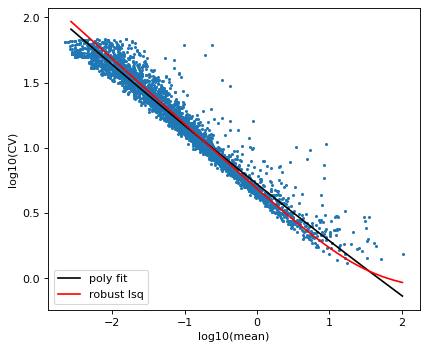

array([ 0.048889  , -0.07626458, -0.02784309, ...,  0.78019458,
        0.59314723,  0.22144539])

In [10]:
skin.chen2016_fit(ada, plot = True, verbose = True)

## create a Xct obj with GRN building:

In [11]:
obj1 = Xct(ada, 'Inflam. FIB', 'Inflam. DC', build_GRN = False, pcNet_name = 'skin_net', mode = 'full', verbose = True)

print(obj1)

initiating an Xct object for interactions from Inflam. FIB (484) to Inflam. DC (81)...
GRNs loaded...
correspondence has been built...
Xct object with the interaction between cells Inflam. FIB X Inflam. DC = 484 X 81
# of genes = 3000 X 3000 
Correspondence = 6000 X 6000


In [12]:
df1 = obj1.fill_metric()
df1

,ligand,receptor,mean_L,mean_R,var_L,var_R,disp_L,disp_R,cv_L,cv_R,cv_res_L,cv_res_R
21,IGF1,NTRK2,0.029522,0.024446,0.067410,0.027285,2.283343,1.116142,8.794479,6.757026,0.156436,-0.338065
31,AREG,NTRK2,0.003443,0.024446,0.005726,0.027285,1.663072,1.116142,21.977261,6.757026,-0.221117,-0.338065
36,FGF2,NTRK2,0.076530,0.024446,0.142827,0.027285,1.866276,1.116142,4.938230,6.757026,-0.075862,-0.338065
38,FGF7,NTRK2,0.449156,0.024446,0.835224,0.027285,1.859543,1.116142,2.034720,6.757026,0.023099,-0.338065
56,BDNF,NTRK2,0.009386,0.024446,0.016305,0.027285,1.737234,1.116142,13.604940,6.757026,-0.094830,-0.338065
...,...,...,...,...,...,...,...,...,...,...,...,...
7974,LAMB1,SV2B,0.192922,0.015761,0.356617,0.019873,1.848509,1.260899,3.095425,8.944272,-0.019347,-0.338065
7980,LAMC3,SV2B,0.343355,0.015761,0.610706,0.019873,1.778645,1.260899,2.276004,8.944272,-0.046932,-0.338065
7984,LAMB2,SV2B,1.027162,0.015761,1.343443,0.019873,1.307918,1.260899,1.128420,8.944272,-0.030466,-0.338065
8113,FSTL1,DIP2A,1.154967,0.066773,1.490066,0.086209,1.290138,1.291068,1.056898,4.397163,0.014484,-0.313400


## permutation mode:

In [13]:
# np.random.seed(1)

# orig_score = np.asarray(obj1.score(method=1))
# pmt_scores = scores(ada, obj1, method = 1, a = 0.8, n = 100)

# enriched, pvals, counts = pmt_test(orig_score, pmt_scores)
# #enriched, counts

# df_enriched = df1.iloc[enriched, :]
# print('Total enriched:', len(df_enriched))
# df_enriched

## mode 'full':

In [14]:
obj1._net_A.shape, obj1._net_B.shape, obj1._w.shape #check

((3000, 3000), (3000, 3000), (6000, 6000))

In [15]:
w12 = obj1._w[:obj1._net_A.shape[0], obj1._net_A.shape[1]:]

np.mean(w12)  

1.0002169791476754

In [16]:
#selected LR pairs
candidates = obj1._candidates(df1)
print(len(candidates))
candidates[:5]

160


['IGF1_NTRK2', 'AREG_NTRK2', 'FGF2_NTRK2', 'FGF7_NTRK2', 'BDNF_NTRK2']

Net(
  (linear1): Linear(in_features=484, out_features=124, bias=True)
  (linear2): Linear(in_features=124, out_features=31, bias=True)
  (linear3): Linear(in_features=31, out_features=2, bias=True)
)
Net(
  (linear1): Linear(in_features=81, out_features=48, bias=True)
  (linear2): Linear(in_features=48, out_features=12, bias=True)
  (linear3): Linear(in_features=12, out_features=2, bias=True)
)
0 5188.46533203125
99 710.5101318359375
199 632.9097900390625
299 590.5418090820312
399 566.173095703125
499 553.3591918945312
599 546.3666381835938
699 542.36572265625
799 539.9539184570312
899 538.40771484375
999 537.3521728515625
1099 536.6038818359375
1199 536.0637817382812
1299 535.6533813476562
1399 535.3528442382812
1499 535.1118774414062
1599 534.9122314453125
1699 534.757080078125
1799 534.643798828125
1899 534.5408325195312
1999 534.4583129882812
2099 534.3782348632812
2199 534.3267822265625
2299 534.2742919921875
2399 534.2295532226562
2499 534.184814453125
2599 534.15087890625
2699 

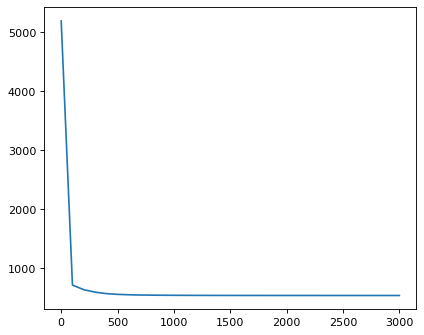

In [17]:
projections, losses = obj1.nn_projection(d = 2, n = 3000, lr = 0.001, plot_loss = True)

In [18]:
# np.savetxt("./data/skin_projections_pair.csv", projections, delimiter="\t")

# projections = np.genfromtxt("./data/skin_projections_pair.csv", delimiter="\t")

In [19]:
df_nn = obj1.nn_output(projections)
df_nn.head()

computing pair-wise distances...
manifold aligned # of pairs: 9000000
adding column 'rank'...
adding column 'correspondence_score'...


,idx,dist,rank,correspondence_score
FOS_CD1B,"(2946, 2516)",0.000003,1,140.040865
C3_TXNIP,"(2880, 744)",0.000003,2,169.704870
TIMP2_ZFP36,"(1102, 2517)",0.000004,3,138.106644
COMP_DNAJB1,"(2965, 2381)",0.000004,4,120.706764
ID2_HLA-DPA1,"(2330, 2987)",0.000005,5,354.556896


In [20]:
#df_nn_to_output = df_nn.iloc[:1000, :]
#df_nn_to_output.to_csv('distances_nn.csv')

[[ 1.        -0.1452785]
 [-0.1452785  1.       ]]


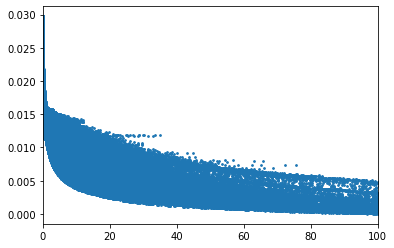

In [21]:
#check corr
select = df_nn['correspondence_score'] != 0
nX = np.asarray(df_nn['correspondence_score'][select])
nY = np.asarray(df_nn['dist'][select])
r = np.corrcoef(nX, nY)
print(r)

plt.scatter(nX, nY, s=3)
plt.xlim(0, 100)
plt.show()

In [22]:
# df_nn_filtered = df_nn.loc[candidates]
# len(df_nn_filtered)

In [23]:
df_nn_filtered = obj1.filtered_nn_output(df_nn, candidates)
df_nn_filtered.head()

manifold aligned # of L-R pairs: 160


,idx,dist,rank,correspondence_score,rank_filtered
CCL2_CXCR4,"(2820, 2548)",0.000596,7631,215.662524,1
CXCL12_CXCR4,"(2919, 2548)",0.000635,8163,227.040061,2
CCL2_CCR7,"(2820, 2138)",0.000762,9698,308.186078,3
CXCL12_CCR7,"(2919, 2138)",0.000802,10212,324.444807,4
VCAM1_ITGB2,"(1458, 491)",0.000840,10719,61.912204,5


In [24]:
df_enriched = obj1.chi2_test(df_nn_filtered, df = 2, pval = 0.05, FDR=True)
df_enriched


Total enriched: 11 / 160


,idx,dist,rank,correspondence_score,rank_filtered,q_val
CCL2_CXCR4,"(2820, 2548)",0.000596,7631,215.662524,1,0.037913
CXCL12_CXCR4,"(2919, 2548)",0.000635,8163,227.040061,2,0.037913
CCL2_CCR7,"(2820, 2138)",0.000762,9698,308.186078,3,0.037913
CXCL12_CCR7,"(2919, 2138)",0.000802,10212,324.444807,4,0.037913
VCAM1_ITGB2,"(1458, 491)",0.000840,10719,61.912204,5,0.037913
CXCL14_CXCR4,"(2994, 2548)",0.000903,11480,401.743027,6,0.037913
CCL19_CXCR4,"(2993, 2548)",0.000921,11667,408.453049,7,0.037913
CXCL14_CCR7,"(2994, 2138)",0.001068,13452,574.098854,8,0.041019
CCL19_CCR7,"(2993, 2138)",0.001086,13668,583.687610,9,0.041019
CXCL1_CCR7,"(2596, 2138)",0.001150,14441,70.730357,10,0.041348


In [25]:
df_nn_filtered.loc['CCL19_CCR7']

idx                     (2993, 2138)
dist                        0.001086
rank                           13668
correspondence_score       583.68761
rank_filtered                      9
p_val                       0.041019
Name: CCL19_CCR7, dtype: object

In [26]:
# i = 0 
# for p in candidates:
#     if df_nn.loc[p].values[2] < 200: #rank < ?
#         i += 1
#         print(p, "idx, dist, rank, score, rank%:", ' '.join(map(str, df_nn.loc[p].values)), f'{round(100* df_nn.loc[p].values[2]/len(df_nn), 5)}%')

# print('\nTotal enriched:', i)

## mode 'comb':

In [27]:
obj2 = Xct(ada, 'Inflam. FIB', 'Inflam. DC', build_GRN = False, pcNet_name = 'skin_net', mode = 'comb', verbose = True)

initiating an Xct object for interactions from Inflam. FIB (484) to Inflam. DC (81)...
GRNs loaded...
correspondence has been built...


In [28]:
w12 = obj2._w[:obj2._net_A.shape[0], obj2._net_A.shape[1]:]

np.mean(w12)  

0.028301679063587458

Net(
  (linear1): Linear(in_features=484, out_features=124, bias=True)
  (linear2): Linear(in_features=124, out_features=31, bias=True)
  (linear3): Linear(in_features=31, out_features=2, bias=True)
)
Net(
  (linear1): Linear(in_features=81, out_features=48, bias=True)
  (linear2): Linear(in_features=48, out_features=12, bias=True)
  (linear3): Linear(in_features=12, out_features=2, bias=True)
)
0 138.69192504882812
99 36.89339828491211
199 32.22517395019531
299 28.70789337158203
399 28.078144073486328
499 27.464431762695312
599 27.261573791503906
699 26.795333862304688
799 26.718448638916016
899 26.842872619628906
999 26.464521408081055


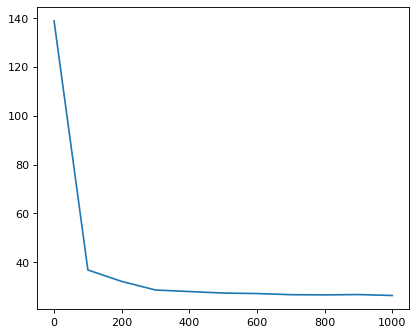

In [29]:
projections2, losses2 = obj2.nn_projection(n = 1000, plot_loss = True)

In [30]:
# np.savetxt("./data/skin_projections_comb.csv", projections2, delimiter="\t")

# projections2 = np.genfromtxt("./data/skin_projections_comb.csv", delimiter="\t")

In [31]:
df_nn2 = obj2.nn_output(projections2)
df_nn2.head()

computing pair-wise distances...
manifold aligned # of pairs: 9000000
adding column 'rank'...
adding column 'correspondence_score'...


,idx,dist,rank,correspondence_score
APOE_HLA-DPB1,"(2975, 2983)",0.000027,1,1209.188602
COL6A6_CD74,"(2673, 2991)",0.000036,2,1659.038905
CXCL12_HLA-DPA1,"(2919, 2987)",0.000067,3,1170.936472
CXCL12_HLA-DPB1,"(2919, 2983)",0.000078,4,1161.141072
APOE_HLA-DPA1,"(2975, 2987)",0.000085,5,1219.389332


[[ 1.         -0.29357968]
 [-0.29357968  1.        ]]


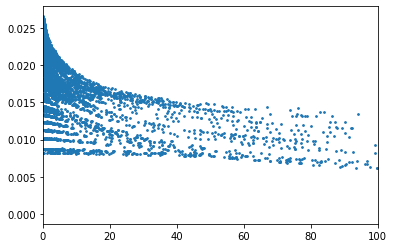

In [32]:
#check corr
select = df_nn2['correspondence_score'] != 0
nX = np.asarray(df_nn2['correspondence_score'][select])
nY = np.asarray(df_nn2['dist'][select])
r = np.corrcoef(nX, nY)
print(r)

plt.scatter(nX, nY, s=3)
plt.xlim(0, 100)
plt.show()

In [33]:
#df_nn_to_output2 = df_nn2.iloc[:1000, :]
#df_nn_to_output2.to_csv('distances_nn2.csv')

In [34]:
df_nn_filtered2 = obj2.filtered_nn_output(df_nn2, candidates)
df_nn_filtered2.head()

manifold aligned # of L-R pairs: 160


,idx,dist,rank,correspondence_score,rank_filtered
CCL19_CCR7,"(2993, 2138)",0.001390,69,583.687610,1
CXCL14_CCR7,"(2994, 2138)",0.001416,71,574.098854,2
CCL19_CXCR4,"(2993, 2548)",0.002477,109,408.453049,3
CXCL14_CXCR4,"(2994, 2548)",0.002503,110,401.743027,4
CXCL12_CCR7,"(2919, 2138)",0.002641,114,324.444807,5


In [35]:
df_enriched2 = obj2.chi2_test(df_nn_filtered2, df = 2, pval=0.05)
df_enriched2


Total enriched: 8 / 160


,idx,dist,rank,correspondence_score,rank_filtered,p_val
CCL19_CCR7,"(2993, 2138)",0.001390,69,583.687610,1,0.002513
CXCL14_CCR7,"(2994, 2138)",0.001416,71,574.098854,2,0.002606
CCL19_CXCR4,"(2993, 2548)",0.002477,109,408.453049,3,0.007957
CXCL14_CXCR4,"(2994, 2548)",0.002503,110,401.743027,4,0.008121
CXCL12_CCR7,"(2919, 2138)",0.002641,114,324.444807,5,0.009037
CCL2_CCR7,"(2820, 2138)",0.002760,119,308.186078,6,0.009865
CXCL12_CXCR4,"(2919, 2548)",0.003727,153,227.040061,7,0.017924
CCL2_CXCR4,"(2820, 2548)",0.003846,155,215.662524,8,0.019078


## mode pairs:

In [36]:
obj3 = Xct(ada, 'Inflam. FIB', 'Inflam. DC', build_GRN = False, pcNet_name = 'skin_net', mode = 'pairs', verbose = True)

initiating an Xct object for interactions from Inflam. FIB (484) to Inflam. DC (81)...
GRNs loaded...
correspondence has been built...


In [37]:
w12 = obj1._w[:obj3._net_A.shape[0], obj3._net_A.shape[1]:]

np.mean(w12)  

1.0002169791476754

Net(
  (linear1): Linear(in_features=484, out_features=124, bias=True)
  (linear2): Linear(in_features=124, out_features=31, bias=True)
  (linear3): Linear(in_features=31, out_features=2, bias=True)
)
Net(
  (linear1): Linear(in_features=81, out_features=48, bias=True)
  (linear2): Linear(in_features=48, out_features=12, bias=True)
  (linear3): Linear(in_features=12, out_features=2, bias=True)
)
0 103.40798950195312
99 27.000225067138672
199 24.52691650390625
299 20.35708236694336
399 19.58228302001953
499 19.44411849975586
599 19.182485580444336
699 19.130340576171875
799 19.097578048706055
899 18.91343116760254
999 18.807632446289062


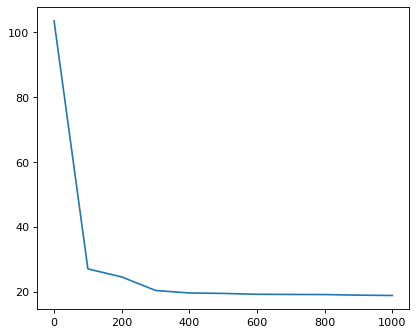

In [38]:
projections3, losses3 = obj3.nn_projection(n = 1000, plot_loss = True)

In [39]:
# np.savetxt("./data/skin_projections_all.csv", projections3, delimiter="\t")

# projections3 = np.genfromtxt("./data/skin_projections_all.csv", delimiter="\t")

In [40]:
df_nn3 = obj3.nn_output(projections3)
df_nn3.head()

computing pair-wise distances...
manifold aligned # of pairs: 9000000
adding column 'rank'...
adding column 'correspondence_score'...


,idx,dist,rank,correspondence_score
CCL19_HLA-DPB1,"(2993, 2983)",0.000029,1,2088.933595
POSTN_HLA-DPB1,"(2977, 2983)",0.000045,2,2162.894687
CCL19_HLA-DPA1,"(2993, 2987)",0.000046,3,2106.555864
CXCL14_HLA-DPA1,"(2994, 2987)",0.000059,4,2071.949596
POSTN_HLA-DPA1,"(2977, 2987)",0.000076,5,2181.140893


[[ 1.         -0.33038736]
 [-0.33038736  1.        ]]


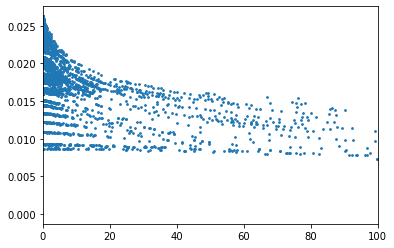

In [41]:
#check corr
select = df_nn3['correspondence_score'] != 0
nX = np.asarray(df_nn3['correspondence_score'][select])
nY = np.asarray(df_nn3['dist'][select])
r = np.corrcoef(nX, nY)
print(r)

plt.scatter(nX, nY, s=3)
plt.xlim(0, 100)
plt.show()

In [42]:
#df_nn_to_output3 = df_nn3.iloc[:20000, :]
#df_nn_to_output3.to_csv('distances_nn3.csv')

In [43]:
df_nn_filtered3 = obj3.filtered_nn_output(df_nn3, candidates)
df_nn_filtered3.head()

manifold aligned # of L-R pairs: 160


,idx,dist,rank,correspondence_score,rank_filtered
CCL19_CCR7,"(2993, 2138)",0.002934,74,583.687610,1
CXCL14_CCR7,"(2994, 2138)",0.002997,75,574.098854,2
CCL19_CXCR4,"(2993, 2548)",0.004124,95,408.453049,3
CXCL14_CXCR4,"(2994, 2548)",0.004187,96,401.743027,4
CXCL12_CCR7,"(2919, 2138)",0.004227,97,324.444807,5


In [44]:
df_enriched3 = obj3.chi2_test(df_nn_filtered3, df = 2, pval = 0.05)
df_enriched3


Total enriched: 8 / 160


,idx,dist,rank,correspondence_score,rank_filtered,p_val
CCL19_CCR7,"(2993, 2138)",0.002934,74,583.687610,1,0.010766
CXCL14_CCR7,"(2994, 2138)",0.002997,75,574.098854,2,0.011226
CCL19_CXCR4,"(2993, 2548)",0.004124,95,408.453049,3,0.021158
CXCL14_CXCR4,"(2994, 2548)",0.004187,96,401.743027,4,0.021798
CXCL12_CCR7,"(2919, 2138)",0.004227,97,324.444807,5,0.022215
CCL2_CCR7,"(2820, 2138)",0.004339,99,308.186078,6,0.023393
CXCL12_CXCR4,"(2919, 2548)",0.005418,132,227.040061,7,0.036226
CCL2_CXCR4,"(2820, 2548)",0.005529,137,215.662524,8,0.037709
